# Housing Price Analysis/Prediction

### To run the clean process, obtain main dataset from here:
https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

### Supplementary wage data was obtained from here:
https://beta.bls.gov/dataViewer/view/timeseries/OEUN000000000000000000004

### Place these in subfolder data/

In [1]:
import os
import pandas as pd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print("imports successful")

imports successful
C:\Users\tyron\repos\kaggle\housing_prices


In [2]:
df = pd.read_csv('data/realtor-data.csv')
wages_df = pd.read_csv('data/wages.csv')

# 1. First take a look at the wages df and see how we can clean it up for our purposes. We are interested in median annual wage by area

In [3]:
wages_df.head(2)

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,17.40,24.28,36.83,"20,770","25,380","36,180","50,490","76,600",NaN,NaN
1,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,37.06,51.40,74.96,"37,110","54,620","77,080","106,910","155,920",NaN,NaN


In [4]:
wages_df = wages_df[['AREA_TITLE', 'PRIM_STATE', 'A_MEDIAN']].rename({'AREA_TITLE': 'area', 'PRIM_STATE': 'state', 'A_MEDIAN': 'annual_median'}, axis=1)
wages_df.head(5)

,area,state,annual_median
0,"Abilene, TX",TX,"36,180"
1,"Abilene, TX",TX,"77,080"
2,"Abilene, TX",TX,"74,270"
3,"Abilene, TX",TX,"111,080"
4,"Abilene, TX",TX,"86,830"


In [5]:
wages_df.dtypes

area             object
state            object
annual_median    object
dtype: object

In [6]:
wages_df['annual_median'] = wages_df['annual_median'].map(lambda x: x.replace(',',''))

In [7]:
def convert_to_float(x):
    try:
        fl = float(x)
        return fl
    except:
        return np.nan

wages_df['annual_median'] = wages_df['annual_median'].map(convert_to_float)
wages_df = wages_df.dropna(subset=['annual_median'])
wages_df['annual_median'] = wages_df['annual_median'].astype(float)

In [8]:
wages_df['state'].unique()

array(['TX', 'PR', 'OH', 'GA', 'OR', 'NY', 'NM', 'LA', 'PA', 'IA', 'AK',
       'MI', 'AL', 'WI', 'NC', 'NJ', 'CA', 'MD', 'WV', 'WA', 'MT', 'ND',
       'VA', 'IL', 'IN', 'ID', 'CO', 'KY', 'FL', 'MO', 'NV', 'WY', 'SC',
       'TN', 'DE', 'MN', 'OK', 'AR', 'AZ', 'NE', 'MS', 'HI', 'KS', 'UT',
       'SD', 'DC', 'ME', 'MA', 'CT', 'VT', 'NH', 'RI'], dtype=object)

In [9]:
# We take the mean of the medians as the medians will have already weeded out outliers
median_df = wages_df.groupby(by=['area', 'state']).mean()
median_df = median_df.reset_index()  

In [10]:
median_df['area'] = median_df['area'].str.split(', ', expand=True).drop([1], axis=1)

In [11]:
median_df.head(5)

,area,state,annual_median
0,Abilene,TX,47096.596491
1,Aguadilla-Isabela,PR,28787.163462
2,Akron,OH,54828.518519
3,Albany,GA,46217.944664
4,Albany,OR,52356.785714


## 1.1 Looks good, write this one back out

In [12]:
median_df.to_csv('data_cleaned/wages_cleaned.csv', index=False)

# 2. Next look at our actual housing data

In [13]:
df[(df['zip_code'] == 0) | (df['zip_code'].isna())]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
679,for_sale,58000.0,3.0,1.0,0.05,"3117 Espada, Ponce, PR",3117 Espada,Ponce,Puerto Rico,NaN,790.0,NaN
917,for_sale,58000.0,3.0,1.0,0.05,"3117 Espada, Ponce, PR",3117 Espada,Ponce,Puerto Rico,NaN,790.0,NaN
1022,for_sale,58000.0,3.0,1.0,0.05,"3117 Espada, Ponce, PR",3117 Espada,Ponce,Puerto Rico,NaN,790.0,NaN
1195,for_sale,650000.0,NaN,NaN,1.40,"233 Rincon, Rincon, PR",233 Rincon,Rincon,Puerto Rico,NaN,NaN,NaN
1451,for_sale,58000.0,3.0,1.0,0.05,"3117 Espada, Ponce, PR",3117 Espada,Ponce,Puerto Rico,NaN,790.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
592642,for_sale,49900.0,1.0,NaN,0.13,"324 Whittaker Rd, Dingmans Ferry, PA",324 Whittaker Rd,Dingmans Ferry,Pennsylvania,NaN,582.0,NaN
620524,for_sale,169000.0,NaN,NaN,5.00,"Wildwood Way, NY",NaN,Wildwood Way,New York,NaN,NaN,NaN
769358,for_sale,405000.0,NaN,1.0,NaN,"417 421 E 90th St Unit 2C, New York, NY",417 421 E 90th St Unit 2C,New York,New York,NaN,NaN,NaN
775769,for_sale,405000.0,NaN,1.0,NaN,"417 421 E 90th St Unit 2C, New York, NY",417 421 E 90th St Unit 2C,New York,New York,NaN,NaN,NaN


In [14]:
df[df['street'] == '522 Navarro']

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
5146,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
5179,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
5205,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
5412,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
6457,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
9290,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
10397,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
11076,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
12409,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN
15160,for_sale,110000.0,3.0,2.0,0.0,"522 Navarro, Gurabo, PR, 00778",522 Navarro,Gurabo,Puerto Rico,778.0,1409.0,NaN


### We can see that there are some listings that have multiple listings but never sell. This is not useful information to us since it doesn't prove the value of the house is what they listed it at. We must clean the data so we only have houses that have actually sold

In [15]:
print(len(df['street'].unique()))
print(len(df['street'].unique())/len(df))

110325
0.11950812373599781


### We can see that only ~12% of our data contains unique addresses

In [16]:
len(df[df['zip_code'].isna()])

205

In [17]:
df[df['zip_code'].isna() & ~df['sold_date'].isna()]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date


### Only 205 of the entries are missing zip code, but all are NA sold_date, so they will be removed by removing sold_date NA 

In [18]:
df = df.dropna(subset=['sold_date', 'price'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456396 entries, 684 to 923157
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        456396 non-null  object 
 1   price         456396 non-null  float64
 2   bed           429473 non-null  float64
 3   bath          438920 non-null  float64
 4   acre_lot      330850 non-null  float64
 5   full_address  456396 non-null  object 
 6   street        455248 non-null  object 
 7   city          456396 non-null  object 
 8   state         456396 non-null  object 
 9   zip_code      456396 non-null  float64
 10  house_size    320287 non-null  float64
 11  sold_date     456396 non-null  object 
dtypes: float64(6), object(6)
memory usage: 45.3+ MB


In [20]:
print(len(df['street'].unique()))
print(len(df['street'].unique())/len(df))

58692
0.12859884836852206


### We can see there are still duplicates even removing the NA rows for sold_date. We will remove completely duplicate rows

In [21]:
df = df.drop_duplicates()
df

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
684,for_sale,76900.0,3.0,2.0,NaN,"E 331 Apt E 331 Alborada Unit E331, Canovanas,...",E 331 Apt E 331 Alborada Unit E331,Canovanas,Puerto Rico,729.0,1200.0,2020-02-28
829,for_sale,110000.0,7.0,3.0,0.09,"B-2 Monte Elena, Dorado, PR, 00949",B-2 Monte Elena,Dorado,Puerto Rico,949.0,1192.0,2019-06-28
4608,for_sale,159000.0,3.0,2.0,NaN,"784 Carretera Unit B302, Caguas, PR, 00725",784 Carretera Unit B302,Caguas,Puerto Rico,725.0,1625.0,2021-09-15
5163,for_sale,380000.0,NaN,NaN,78.66,Km 12 5 Carretera 182 Km 12 5 Bo Guayabota Yab...,Km 12 5 Carretera 182 Km 12 5 Bo Guayabota Yab...,Yabucoa,Puerto Rico,767.0,NaN,2021-03-15
10344,for_sale,950000.0,5.0,4.0,0.99,"46 Water Isle, Saint Thomas, VI, 00802",46 Water Isle,Saint Thomas,Virgin Islands,802.0,5000.0,2013-10-11
...,...,...,...,...,...,...,...,...,...,...,...,...
923135,for_sale,1649000.0,4.0,3.0,0.17,"10 Butler St, Cos Cob, CT, 06807",10 Butler St,Cos Cob,Connecticut,6807.0,2178.0,2016-05-10
923136,for_sale,779000.0,4.0,3.0,0.59,"44 Laura Dr, Airmont, NY, 10952",44 Laura Dr,Airmont,New York,10952.0,1816.0,2004-12-22
923144,for_sale,1595000.0,5.0,4.0,0.16,"65 Bruce Park Ave, Greenwich, CT, 06830",65 Bruce Park Ave,Greenwich,Connecticut,6830.0,2231.0,2014-02-19
923146,for_sale,4595000.0,4.0,5.0,0.14,"51 Connecticut Ave, Greenwich, CT, 06830",51 Connecticut Ave,Greenwich,Connecticut,6830.0,4863.0,2016-01-19


In [22]:
df[df.duplicated(['full_address'])]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
209198,for_sale,599000.0,NaN,NaN,1.14,"53 Meadow Farm Rd, Centerville, MA, 02632",53 Meadow Farm Rd,Centerville,Massachusetts,2632.0,NaN,2004-05-05
227070,for_sale,560000.0,4.0,2.0,0.20,"54 Plainfield Ave, Shrewsbury, MA, 01545",54 Plainfield Ave,Shrewsbury,Massachusetts,1545.0,2640.0,1998-09-28
387684,for_sale,135000.0,2.0,2.0,NaN,"East Haven, CT, 06513",NaN,East Haven,Connecticut,6513.0,1066.0,2019-10-22
387949,for_sale,189900.0,2.0,2.0,0.08,"Hamden, CT, 06517",NaN,Hamden,Connecticut,6517.0,855.0,2005-01-31
445259,for_sale,535000.0,3.0,3.0,1.18,"36 Jardin Dr, East Haven, CT, 06513",36 Jardin Dr,East Haven,Connecticut,6513.0,1730.0,2018-10-18
...,...,...,...,...,...,...,...,...,...,...,...,...
920912,for_sale,1395000.0,3.0,3.0,NaN,"115 River Rd Apt 12, Cos Cob, CT, 06807",115 River Rd Apt 12,Cos Cob,Connecticut,6807.0,1926.0,2003-09-01
921985,for_sale,485000.0,3.0,2.0,0.11,"17 Lafayette Ave, Hillsdale, NJ, 07642",17 Lafayette Ave,Hillsdale,New Jersey,7642.0,NaN,2020-02-28
922971,for_sale,12250000.0,6.0,9.0,2.00,"25 Lindsay Dr, Greenwich, CT, 06830",25 Lindsay Dr,Greenwich,Connecticut,6830.0,7770.0,2013-03-11
922973,for_sale,5800000.0,6.0,9.0,1.00,"49 Doubling Rd, Greenwich, CT, 06830",49 Doubling Rd,Greenwich,Connecticut,6830.0,7497.0,2015-04-21


In [23]:
df[df['full_address'] == '53 Meadow Farm Rd, Centerville, MA, 02632']

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
199405,for_sale,2399000.0,4.0,4.0,1.02,"53 Meadow Farm Rd, Centerville, MA, 02632",53 Meadow Farm Rd,Centerville,Massachusetts,2632.0,3499.0,2004-05-05
209198,for_sale,599000.0,NaN,NaN,1.14,"53 Meadow Farm Rd, Centerville, MA, 02632",53 Meadow Farm Rd,Centerville,Massachusetts,2632.0,NaN,2004-05-05


### Our first indicate of poor data quality. The exact same address with wildly varying prices, inaccurate arceage information, and missing information.

In [24]:
df[df['street'] == '49 Doubling Rd']

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
460871,for_sale,5800000.0,6.0,9.0,1.0,"49 Doubling Rd, Greenwich, CT, 06830",49 Doubling Rd,Greenwich,Connecticut,6830.0,9813.0,2015-04-21
922973,for_sale,5800000.0,6.0,9.0,1.0,"49 Doubling Rd, Greenwich, CT, 06830",49 Doubling Rd,Greenwich,Connecticut,6830.0,7497.0,2015-04-21


In [25]:
df[df['full_address'] == 'East Haven, CT, 06513']

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
384821,for_sale,499900.0,NaN,NaN,7.4,"East Haven, CT, 06513",NaN,East Haven,Connecticut,6513.0,NaN,2015-12-07
387684,for_sale,135000.0,2.0,2.0,NaN,"East Haven, CT, 06513",NaN,East Haven,Connecticut,6513.0,1066.0,2019-10-22


### Due to the clear inaccuracies between the exact same addresses, all these instances will be dropped.

In [26]:
idx = df[df.duplicated(['full_address'])].index
df = df.drop(idx)
df[df.duplicated(['full_address'])]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date


In [27]:
len(df[df['price'] <= 0])

1

In [28]:
# Drop the 0 housing price row
df = df[df['price'] > 0]

# Outliers

In [29]:
# create a temporary view with dropped na so we can easily view outliers
# convert to float types as they were being read in as object for some reason
df['bed'] = df['bed'].astype(float)
df['bath'] = df['bath'].astype(float)

df_outlier = df.dropna()
df_outlier.dtypes

status           object
price           float64
bed             float64
bath            float64
acre_lot        float64
full_address     object
street           object
city             object
state            object
zip_code        float64
house_size      float64
sold_date        object
dtype: object

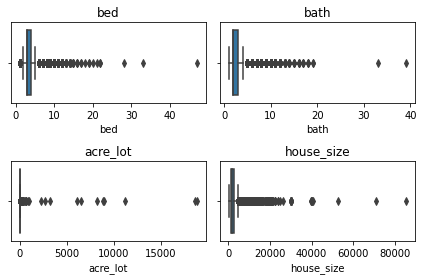

In [30]:
def plot_box(df, cols):
    fig, (ax1,ax2) = plt.subplots(2,2)
    
    sns.boxplot(x=df[cols[0]], ax=ax1[0])
    ax1[0].set_title(cols[0])
    sns.boxplot(x=df[cols[1]], ax=ax1[1])
    ax1[1].set_title(cols[1])

    sns.boxplot(x=df[cols[2]], ax=ax2[0])
    ax2[0].set_title(cols[2])
    sns.boxplot(x=df[cols[3]], ax=ax2[1])
    ax2[1].set_title(cols[3])

    fig.tight_layout()
    # fig.show()
    
plot_box(df_outlier, ['bed','bath','acre_lot','house_size'])

In [31]:
df[df['bed']>20]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
54659,for_sale,12500000.0,33.0,15.0,89.00,"310 Old Stockbridge Rd, Lenox, MA, 01240",310 Old Stockbridge Rd,Lenox,Massachusetts,1240.0,20821.0,1999-05-14
205673,for_sale,3250000.0,28.0,33.0,5.16,"70 Main St, Wellfleet, MA, 02667",70 Main St,Wellfleet,Massachusetts,2667.0,8910.0,1980-05-08
222353,for_sale,15000000.0,29.0,30.0,3.25,"540 W Lake Dr, Montauk, NY, 11954",540 W Lake Dr,Montauk,New York,11954.0,NaN,1995-05-10
479067,for_sale,9950000.0,22.0,15.0,0.06,"318 W 22nd St, New York City, NY, 10011",318 W 22nd St,New York City,New York,10011.0,7315.0,2012-01-31
525746,for_sale,6200000.0,22.0,19.0,2.50,"61 Crows Nest Rd, Tuxedo Park, NY, 10987",61 Crows Nest Rd,Tuxedo Park,New York,10987.0,20000.0,2015-10-01
536923,for_sale,120000000.0,123.0,123.0,NaN,"421 W 250th St, New York City, NY, 10471",421 W 250th St,New York City,New York,10471.0,NaN,2012-06-29
633434,for_sale,729000.0,25.0,NaN,0.05,"7 S Richards Ave, Ventnor, NJ, 08406",7 S Richards Ave,Ventnor,New Jersey,8406.0,NaN,2019-06-17
672764,for_sale,799995.0,31.0,28.0,0.09,"134 E Schellenger Ave, Wildwood, NJ, 08260",134 E Schellenger Ave,Wildwood,New Jersey,8260.0,NaN,2022-04-13
672965,for_sale,1399000.0,47.0,39.0,0.32,"121-123 W Roberts Ave, Wildwood, NJ, 08260",121-123 W Roberts Ave,Wildwood,New Jersey,8260.0,14000.0,2022-04-15
714764,for_sale,1299000.0,21.0,8.0,0.73,"667-681 Easton Rd, Riegelsville, PA, 18077",667-681 Easton Rd,Riegelsville,Pennsylvania,18077.0,8878.0,1997-11-03


### After looking these up online, 4221 W 250th ST is listed incorrectly, 121-123 W Roberts Ave is a motel, 7 S Richards Ave, Ventnor definitely does not have this many baths. Only 310 Old Stockbridge is an actual mansion with the listed number of beds and baths. We will dropp all outliers of bed > 20 except for 310 Stockbridge

In [32]:
def drop_sub_df(df, sub_df, msg):
    num_drop = len(sub_df)
    total = len(df)
    print('Dropping {0} rows of {1} due to "{2}". Expect {3} remaining rows.'
      .format(num_drop, total, msg, total-num_drop))
    new_df = df.drop(sub_df.index)
    print('Rows after dropping: {0}'.format(len(new_df)))
    return new_df

df = drop_sub_df(df, df[(df['bed'] > 20) & (df['street'] != '310 Old Stockbridge Rd')], 'outlier beds')

Dropping 9 rows of 59256 due to "outlier beds". Expect 59247 remaining rows.
Rows after dropping: 59247


In [33]:
df[df['bath'] > 20]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date


### Removing the bed outliers also removed our bath outliers

In [34]:
df[df['acre_lot'] > 10000]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
221570,for_sale,250000.0,3.0,3.0,18817.00,"8 Sunset Rd, Narragansett, RI, 02882",8 Sunset Rd,Narragansett,Rhode Island,2882.0,1532.0,2020-09-14
464718,for_sale,520000.0,NaN,NaN,49299.44,"214 Osborne Ter, Newark, NJ, 07112",214 Osborne Ter,Newark,New Jersey,7112.0,NaN,2020-07-06
472477,for_sale,399000.0,3.0,2.0,58100.00,"325 Belgrove Dr, Kearny, NJ, 07032",325 Belgrove Dr,Kearny,New Jersey,7032.0,NaN,1995-03-16
475692,for_sale,485000.0,4.0,3.0,100000.00,"364 Farley Ave, Scotch Plains, NJ, 07076",364 Farley Ave,Scotch Plains,New Jersey,7076.0,NaN,1974-11-08
496659,for_sale,449000.0,4.0,3.0,36914.83,"13 Legion Pl, Woodbridge Proper, NJ, 07095",13 Legion Pl,Woodbridge Proper,New Jersey,7095.0,NaN,2013-01-08
603262,for_sale,379900.0,3.0,3.0,11236.00,"9 Stillwell Rd, South Brunswick, NJ, 08824",9 Stillwell Rd,South Brunswick,New Jersey,8824.0,2263.0,2021-05-13
611526,for_sale,515000.0,4.0,3.0,18602.89,"24 Cider Mill Cir, Raritan, NJ, 08822",24 Cider Mill Cir,Raritan,New Jersey,8822.0,2184.0,1989-10-06


### After looking up online, only the acreages below 20,000 are real. and 8 Sunset Rd is wrong as well

In [35]:
df = drop_sub_df(df, df[(df['acre_lot'] > 20000) | (df['street'] == '8 Sunset Rd')], 'acre_lot outliers')

Dropping 5 rows of 59247 due to "acre_lot outliers". Expect 59242 remaining rows.
Rows after dropping: 59242


In [36]:
df[df['house_size'] > 35000]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
114959,for_sale,309900.0,3.0,2.0,NaN,"28 Adelaide Ave Unit 28, Methuen, MA, 01844",28 Adelaide Ave Unit 28,Methuen,Massachusetts,1844.0,99999.0,2022-01-12
466123,for_sale,1500000.0,4.0,4.0,0.91,"540 Helena Ave, Wyckoff, NJ, 07481",540 Helena Ave,Wyckoff,New Jersey,7481.0,39600.0,2021-01-21
466559,for_sale,389000.0,1.0,1.0,0.27,"720 W 173rd St Apt 5, New York, NY, 10032",720 W 173rd St Apt 5,New York,New York,10032.0,40720.0,2017-10-25
471906,for_sale,600000.0,7.0,5.0,0.19,"447 New England Ter, City of Orange Township, ...",447 New England Ter,City of Orange Township,New Jersey,7050.0,39996.0,2018-01-24
473403,for_sale,649000.0,8.0,4.0,0.07,"290 21st St, Irvington, NJ, 07111",290 21st St,Irvington,New Jersey,7111.0,39996.0,2018-07-02
473878,for_sale,2490000.0,6.0,5.0,0.91,"2 Wentworth Rd, Summit, NJ, 07901",2 Wentworth Rd,Summit,New Jersey,7901.0,39901.0,2008-10-14
477234,for_sale,12500000.0,NaN,12.0,NaN,"80 Granite Ave, Staten Island, NY, 10303",80 Granite Ave,Staten Island,New York,10303.0,42546.0,1994-08-08
515997,for_sale,1250000.0,6.0,5.0,1.21,"639 Pawnee Ln, Franklin Lakes, NJ, 07417",639 Pawnee Ln,Franklin Lakes,New Jersey,7417.0,52708.0,2018-08-07
635272,for_sale,169000.0,3.0,1.0,0.02,"3630 Winchester Ave, Atlantic City, NJ, 08401",3630 Winchester Ave,Atlantic City,New Jersey,8401.0,70626.0,2017-12-27
643361,for_sale,1100000.0,NaN,NaN,0.28,"5139 Wayne Ave, Philadelphia, PA, 19144",5139 Wayne Ave,Philadelphia,Pennsylvania,19144.0,36000.0,1991-10-28


### Only one of these is valid (80 Granite Ave)

In [37]:
df = drop_sub_df(df, df[(df['house_size'] > 35000) & (df['street'] != '80 Granite Ave')], 'house_size outliers')

Dropping 11 rows of 59242 due to "house_size outliers". Expect 59231 remaining rows.
Rows after dropping: 59231


### This has brought up an interesting value, some of the floats in the bed column are being held as numpy ndarrays. Must convert these to single floats

In [38]:
df[df['house_size'] > 35000]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
477234,for_sale,12500000.0,NaN,12.0,NaN,"80 Granite Ave, Staten Island, NY, 10303",80 Granite Ave,Staten Island,New York,10303.0,42546.0,1994-08-08


In [39]:
def cast_numeric(df, col):
    df[col] = df[col].apply(lambda x: float(x))
    return df

df = cast_numeric(df, 'bed')
df = cast_numeric(df, 'bath')
df = cast_numeric(df, 'house_size')
df = cast_numeric(df, 'acre_lot')
df = cast_numeric(df, 'price')

In [40]:
df[df['house_size'] > 35000]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
477234,for_sale,12500000.0,NaN,12.0,NaN,"80 Granite Ave, Staten Island, NY, 10303",80 Granite Ave,Staten Island,New York,10303.0,42546.0,1994-08-08


## Save one with just dropping NA without impute
**NOTE:: All the feature engineering and machine learning techniques in `learn.ipynb` were applied to this dataset and they consistently performed worse than the imputed dataset. This could be bias leaking in through the imputing methods, but without more data it is difficult to determine how well any one model would generalize without simply looking at our test results, therefore I removed this one from the process in order to reduce time taken to train the models**

In [53]:
# dropped = df.drop(['full_address', 'street', 'status'], axis=1)

## fill acre_lot with 0 since NA has shown to be a lot of apartments with no acre
# dropped['acre_lot'] = dropped['acre_lot'].fillna(0)
# dropped = dropped.dropna(how='any')
# dropped.to_csv('data_cleaned/housing_dropped.csv', index=False)

# Impute
Next, look at the remaining nulls to see what we're missing and/or if we can impute them.

In [41]:
def print_nulls(df):
    print('{0:<12} | {1:<12} | {2:<12}'.format('column', 'num nulls', 'ratio (%)'))
    print('-'*42)
    total = df.shape[0]
                                               
    for col in df.columns:
        num_null = df[col].isna().sum()
        if num_null != 0:
            print('{0:<12} | {1:<12} | {2:<12}'.format(col, num_null, f'{(float(num_null)/total)*100:.2f}%'))

print_nulls(df)

column       | num nulls    | ratio (%)   
------------------------------------------
bed          | 3869         | 6.53%       
bath         | 3166         | 5.35%       
acre_lot     | 13993        | 23.62%      
street       | 122          | 0.21%       
house_size   | 16151        | 27.27%      


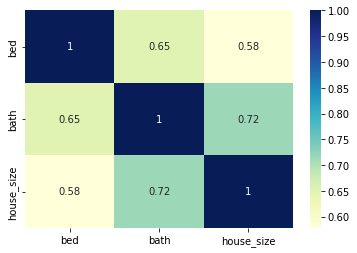

In [42]:
dataplot = sns.heatmap(df[['bed', 'bath', 'house_size']].corr(), cmap="YlGnBu", annot=True)

# displaying heatmap
plt.show()

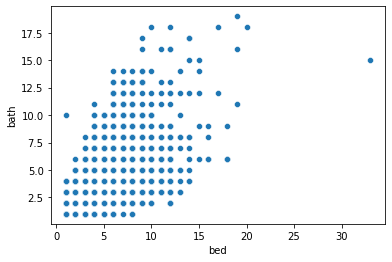

In [43]:
plt.figure()
sctter = sns.scatterplot(x=df['bed'], y=df['bath'])
plt.show()

### bed and bath both have under 7% missing values, however acre_lot and house_size are missing many more values. Number of bed and baths will likely be an indicator of house size. Furthermore bed is a high indicator of bath and vice versa, therefore we need to drop any columns where both bed and bath are missing.

In [44]:
df = drop_sub_df(df, df[df['bed'].isna() & df['bath'].isna()], 'Na bath and Na bed')

Dropping 2711 rows of 59231 due to "Na bath and Na bed". Expect 56520 remaining rows.
Rows after dropping: 56520


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def impute_feature_linearly(df, labeled, unlabeled, feature, predictor_feature, test_size,
                            plot=False, hasna=False):
    """
    """  
        
    y = labeled[feature]
    u_index = unlabeled.index
    
    if len(predictor_feature) == 1:
        single_predictor = True
        predictor_feature = predictor_feature[0]
        X = labeled[predictor_feature].values.reshape(-1,1)
    else:
        single_predictor = False
        X = labeled[predictor_feature].values
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
       
    # print(X_train)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(lr.score(X_train, y_train))
    # return lr
    
    y_pred = lr.predict(X_test)
    
    if plot:
        # sctter = sns.scatterplot(x=X_test['bed'], y=y_test)
        # lnplt = sns.lineplot(x=X_test['bed'], y=y_pred, color='k')
        plt.scatter(X_test, y_test, color ='b')
        plt.plot(X_test, y_pred, color ='k')
        plt.show()
    
    if single_predictor:
        series = unlabeled[predictor_feature].apply(lambda x: lr.predict(np.array(x).reshape(-1,1)))
    else:
        vals = unlabeled[predictor_feature].values
        preds = lr.predict(vals)
        series = pd.Series(preds, index=u_index)
    
    df[feature].fillna(series, inplace=True)
        
    return df

0.43855807821290105


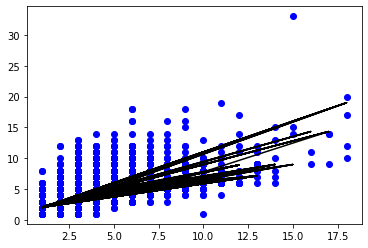

In [46]:
# round to the nearest whole number of a bedroom
labeled = df[~(df['bath'].isna() | df['bed'].isna())]
unlabeled = df[~df['bath'].isna() & df['bed'].isna()]
df_imputed = impute_feature_linearly(df, labeled, unlabeled, 'bed', ['bath'], 0.75, plot=True)
df_imputed['bed'] = df_imputed['bed'].apply(lambda x: float(np.round(x)))

0.4552957671960177


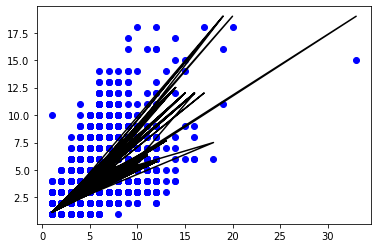

In [47]:
# round to the nearest 0.5 of a bath
labeled = df[~(df['bed'].isna() | df['bath'].isna())]
unlabeled = df[~df['bed'].isna() & df['bath'].isna()]
df_imputed = impute_feature_linearly(df_imputed, labeled, unlabeled, 'bath', ['bed'], 0.75, plot=True)
df_imputed['bath'] = df_imputed['bath'].apply(lambda x: float(np.round(x*2)/2))

In [48]:
labeled = df[~(df['house_size'].isna())]
unlabeled = df[df['house_size'].isna()]
df_imputed = impute_feature_linearly(df_imputed, labeled, unlabeled, 'house_size', ['bed','bath'], 0.75, plot=False)
df_imputed['house_size'] = df_imputed['house_size'].apply(lambda x: float(np.round(x)))

0.6050978892032204


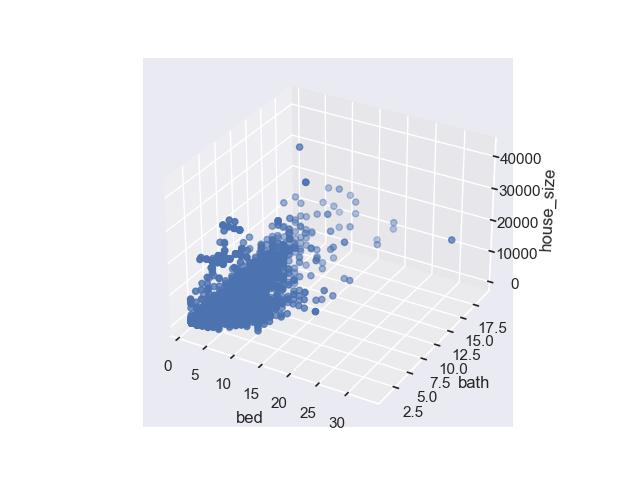

In [49]:
%matplotlib widget
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df_imputed['bed']
y = df_imputed['bath']
z = df_imputed['house_size']

ax.set_xlabel("bed")
ax.set_ylabel("bath")
ax.set_zlabel("house_size")

ax.scatter(x, y, z)

plt.show()

### DropNA on acre_lot since we do not have the means to accurately impute it

In [51]:
# df_imputed['acre_lot'] = df_imputed['acre_lot'].fillna(0)
df_imputed = df_imputed.dropna(subset=['acre_lot'])
df_imputed['acre_lot'].isna().any()

False

# Output 
We will now output the current data as the cleaned dataframe. We may want to impute some missing values, but that will change based on the prediction techniques we need to use.

In [52]:
df_imputed.to_csv('data_cleaned/housing_imputed.csv', index=False)

In [44]:
# We see no rows dropped to NA
df_cs = df[['city', 'state', 'full_address', 'zip_code', 'price']].dropna(how='all')
df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56520 entries, 684 to 923147
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          56520 non-null  object 
 1   state         56520 non-null  object 
 2   full_address  56520 non-null  object 
 3   zip_code      56520 non-null  float64
 4   price         56520 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.6+ MB


In [ ]:
state_prices = df_cs[['state','price']].groupby('state').mean().sort_values(by='price')
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=state_prices.index, y=state_prices['price'], palette=sns.color_palette("BuGn_r", n_colors=len(state_prices) + 4), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()